In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading the BF data

In [12]:
bf_path = '/content/drive/MyDrive/ALL_CLEAN_DEIDEN_NAME AND ECMO DATA(Sheet1) (1) (version 2).csv'
cols = ['ID', 'age_days', 'weight', 'study_height', 'Diagnosis']
df = pd.read_csv(bf_path, usecols=cols)

for col in ['weight', 'study_height', 'age_days']:
    s = pd.to_numeric(df[col], errors='coerce')
    mx = s.max(skipna=True)
    if pd.notna(mx) and mx != 0:
        df[col] = s / mx
    else:
        df[col] = s
print(df.head())

   ID  age_days            Diagnosis    weight  study_height
0   1  0.018213       Cardiac Arrest  0.042214      0.344538
1   2  0.072852       Cardiac Arrest  0.070000      0.431373
2   3  0.793776               Sepsis  0.403571      0.896359
3   4  0.000287  Respiratory Failure  0.022786      0.268908
4   5  0.000287  Respiratory Failure  0.023571      0.285714


In [13]:
diag_clean = (
    df['Diagnosis']
      .astype('string')
      .str.strip()
      .str.replace(r'\s+', ' ', regex=True)
      .fillna('Unknown')
)

codes, uniques = pd.factorize(diag_clean, sort=True)
df['Diagnosis'] = codes.astype('int64')
diagnosis_mapping = {cat: int(i) for i, cat in enumerate(uniques)}
print("Diagnosis mapping (category -> code):", diagnosis_mapping)

# Peek
print(df.head())

Diagnosis mapping (category -> code): {'Cardiac Arrest': 0, 'Cardiogenic Shock': 1, 'Respiratory Failure': 2, 'Sepsis': 3, 'Septic shock': 4}
   ID  age_days  Diagnosis    weight  study_height
0   1  0.018213          0  0.042214      0.344538
1   2  0.072852          0  0.070000      0.431373
2   3  0.793776          3  0.403571      0.896359
3   4  0.000287          2  0.022786      0.268908
4   5  0.000287          2  0.023571      0.285714


In [14]:
df.shape

(72, 5)

In [15]:
df['Diagnosis']

,Diagnosis
0,0
1,0
2,3
3,2
4,2
...,...
67,3
68,2
69,2
70,2


### No normalization!

FEAT_DIM = 4
Total valid IDs: 43 | Pos IDs: 14 | Neg IDs: 29
TARGET_W=6 (non-Time columns)
Fixed input height after de-dup (all IDs): H=360

=== 10-Fold CV (by patient ID; TEST metrics saved) ===

--- Fold 1/14 ---
 train files: 898 | val files: 113 | test files: 179


 Fold  1 | TEST AUC=0.9195 | TEST ACC=0.9721 | n=179


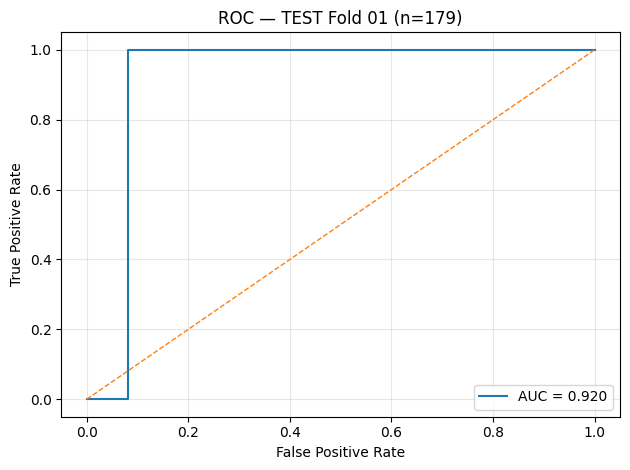

Saved ROC to roc_test_fold_01.png

--- Fold 2/14 ---
 train files: 958 | val files: 118 | test files: 114


 Fold  2 | TEST AUC=0.5152 | TEST ACC=0.8596 | n=114


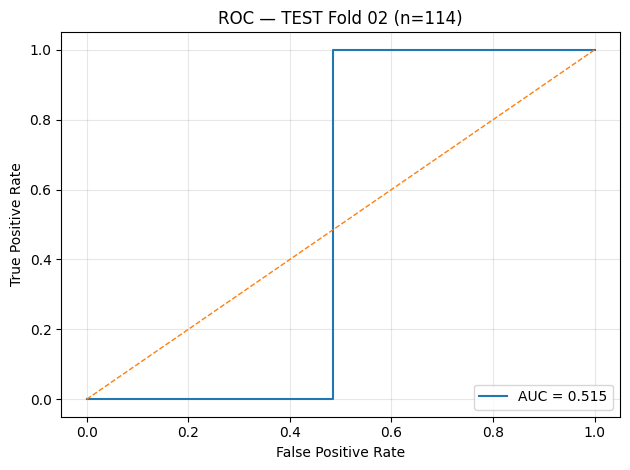

Saved ROC to roc_test_fold_02.png

--- Fold 3/14 ---
 train files: 931 | val files: 218 | test files: 41


 Fold  3 | TEST AUC=0.7524 | TEST ACC=0.8537 | n=41


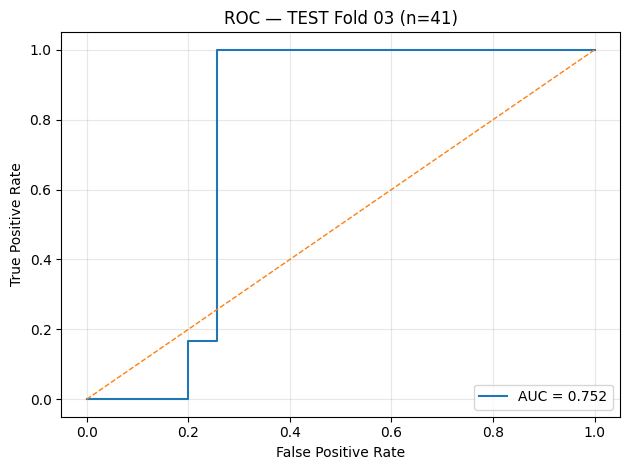

Saved ROC to roc_test_fold_03.png

--- Fold 4/14 ---
 train files: 978 | val files: 129 | test files: 83


 Fold  4 | TEST AUC=1.0000 | TEST ACC=0.5904 | n=83


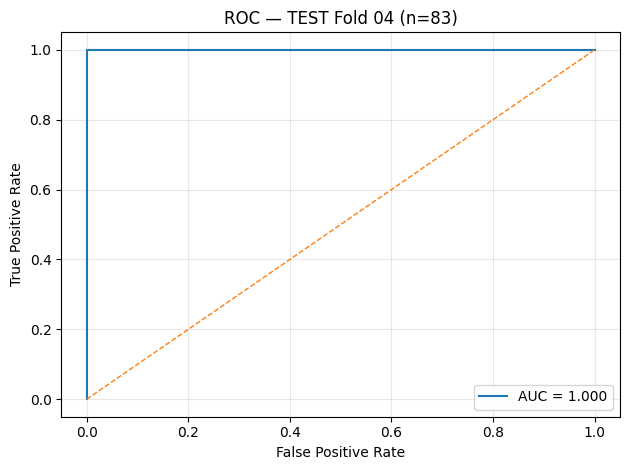

Saved ROC to roc_test_fold_04.png

--- Fold 5/14 ---
 train files: 932 | val files: 234 | test files: 24


 Fold  5 | TEST AUC=1.0000 | TEST ACC=0.8333 | n=24


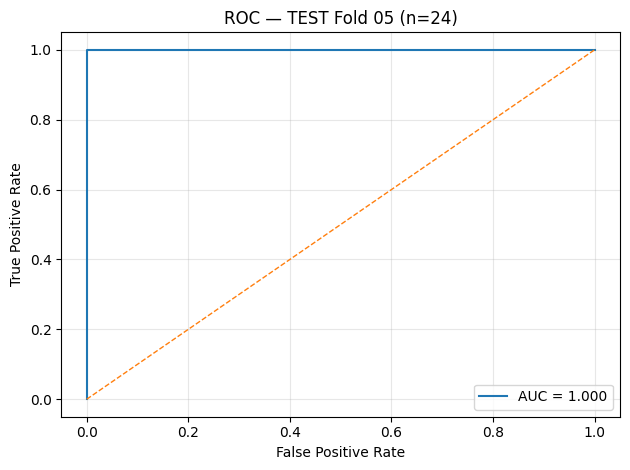

Saved ROC to roc_test_fold_05.png

--- Fold 6/14 ---
 train files: 987 | val files: 100 | test files: 103


 Fold  6 | TEST AUC=0.9990 | TEST ACC=0.2524 | n=103


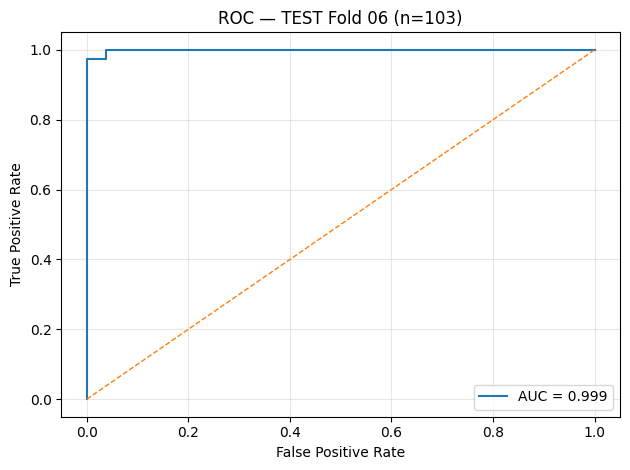

Saved ROC to roc_test_fold_06.png

--- Fold 7/14 ---
 train files: 940 | val files: 234 | test files: 16


 Fold  7 | TEST AUC=0.8667 | TEST ACC=0.9375 | n=16


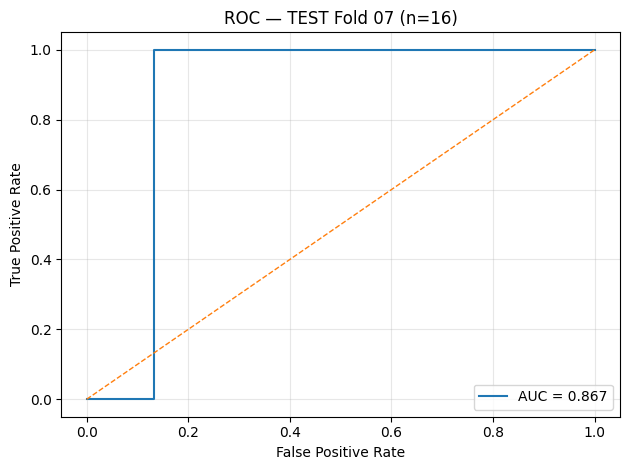

Saved ROC to roc_test_fold_07.png

--- Fold 8/14 ---
 train files: 930 | val files: 207 | test files: 53


 Fold  8 | TEST AUC=1.0000 | TEST ACC=1.0000 | n=53


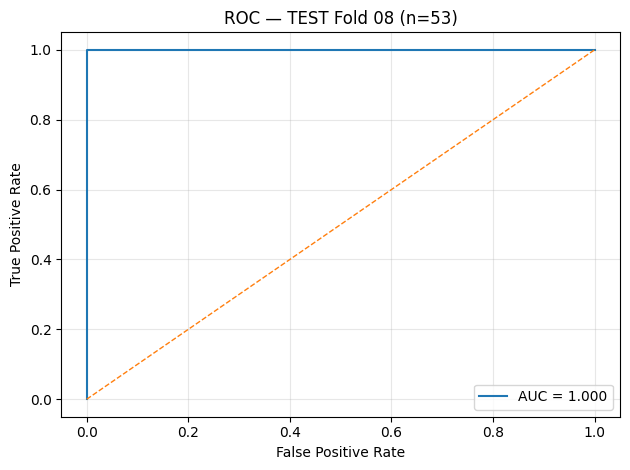

Saved ROC to roc_test_fold_08.png

--- Fold 9/14 ---
 train files: 867 | val files: 234 | test files: 89


 Fold  9 | TEST AUC=1.0000 | TEST ACC=0.2247 | n=89


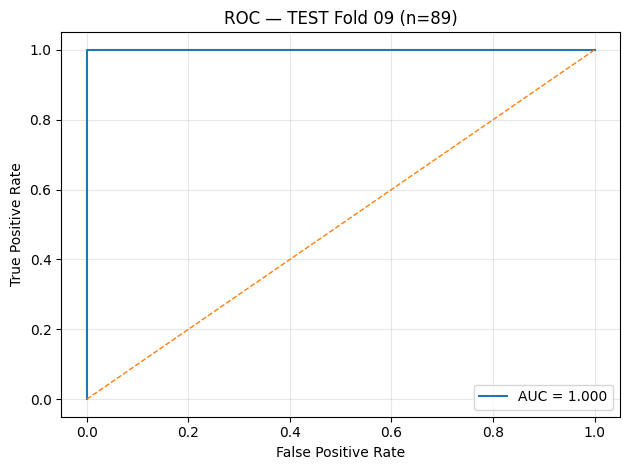

Saved ROC to roc_test_fold_09.png

--- Fold 10/14 ---
 train files: 935 | val files: 234 | test files: 21


 Fold 10 | TEST AUC=0.8500 | TEST ACC=0.9524 | n=21


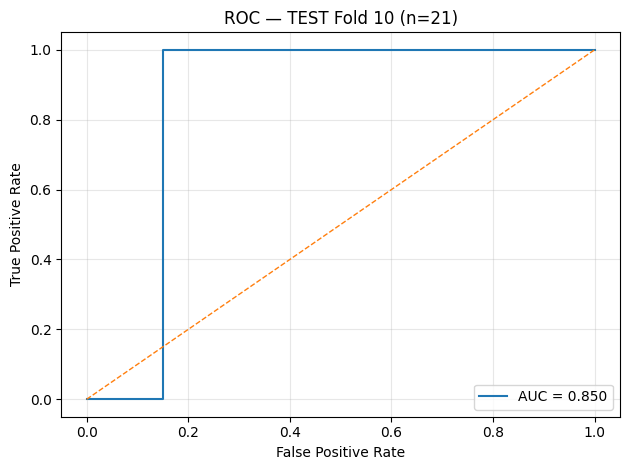

Saved ROC to roc_test_fold_10.png

--- Fold 11/14 ---
 train files: 903 | val files: 202 | test files: 85


 Fold 11 | TEST AUC=0.3158 | TEST ACC=0.5529 | n=85


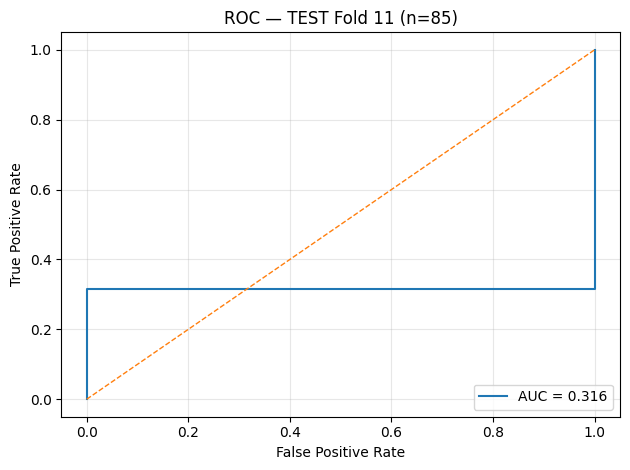

Saved ROC to roc_test_fold_11.png

--- Fold 12/14 ---
 train files: 830 | val files: 202 | test files: 158


 Fold 12 | TEST AUC=1.0000 | TEST ACC=1.0000 | n=158


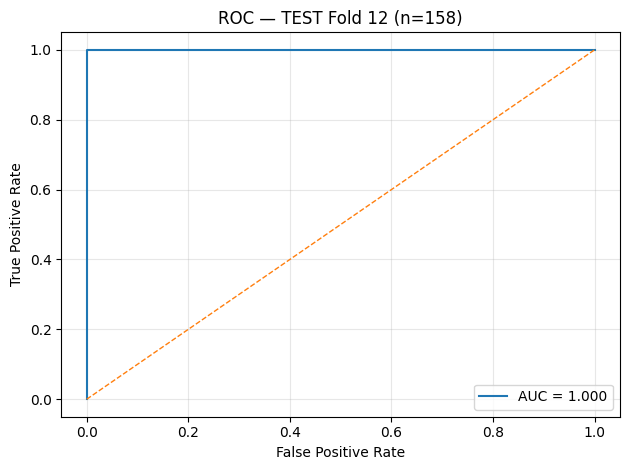

Saved ROC to roc_test_fold_12.png

--- Fold 13/14 ---
 train files: 991 | val files: 118 | test files: 81


 Fold 13 | TEST AUC=0.0000 | TEST ACC=0.4815 | n=81


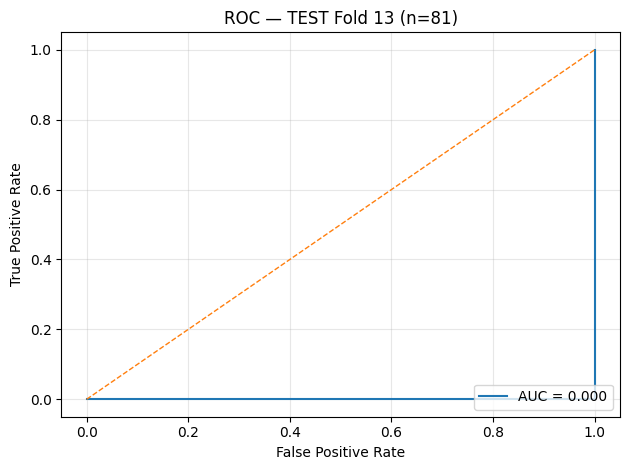

Saved ROC to roc_test_fold_13.png

--- Fold 14/14 ---
 train files: 929 | val files: 118 | test files: 143


 Fold 14 | TEST AUC=1.0000 | TEST ACC=0.0629 | n=143


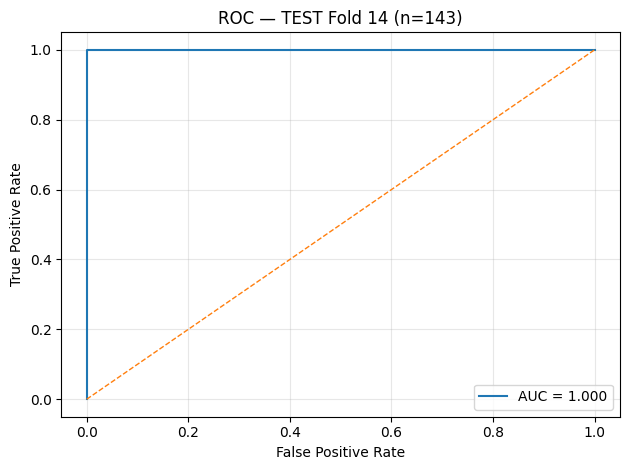

Saved ROC to roc_test_fold_14.png

Mean TEST AUC: 0.8013 ± 0.2998
Mean TEST ACC: 0.6838 ± 0.3106

Saved TEST-only metrics to cv_fold_test_metrics.csv and ROC plots to roc_test_fold_XX.png


In [16]:
from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_nozero_181920212223_1800"
POS_PATIENTS = {1, 2, 16, 19, 21, 22, 25, 37, 39, 43, 44, 47, 50, 56, 58, 62, 65, 66, 73, 78}

BATCH_SIZE       = 3
EPOCHS           = 100
LR               = 1e-4
SEED             = 1
K_FOLDS          = 14

# (kept for reference; not used to fix height)
TARGET_H = 400

# =========================
# Noise config (train-time augmentation only, EEG input only)
# =========================
TRAIN_ADD_GAUSS_NOISE = True
TRAIN_NOISE_FRAC      = 0.0   # set >0 to actually add noise
TRAIN_NOISE_PROB      = 1.0
EPS_STD               = 1e-8

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# =========================
# Helpers
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')  # e.g., "ID76-2_..." -> 76

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def label_for_id(pid: int) -> int:
    return 1 if pid in POS_PATIENTS else 0

def label_for_file(p: Path) -> int:
    pid = patient_num_from_path(p)
    return label_for_id(pid) if pid is not None else 0

# =========================
# Load your existing features DataFrame: must exist as `df`
# Columns: 'ID' + your feature columns (3 in your current setup)
# =========================
feats_df = df.copy()  # <-- expects `df` already in memory
if "ID" not in feats_df.columns:
    raise RuntimeError("Your features DataFrame must contain column 'ID'.")

FEAT_COLS = [c for c in feats_df.columns if c != "ID"]
FEAT_DIM = len(FEAT_COLS)
print("FEAT_DIM =", FEAT_DIM)

# Clean and index by ID; drop rows with missing any of the features
feats_df["ID"] = pd.to_numeric(feats_df["ID"], errors="coerce").astype("Int64")
feats_df = feats_df.dropna(subset=["ID"] + FEAT_COLS).copy()
feats_df["ID"] = feats_df["ID"].astype(int)
ID_TO_FEAT = {
    int(row["ID"]): row[FEAT_COLS].astype("float32").to_numpy()
    for _, row in feats_df.iterrows()
}

# =========================
# Enumerate EEG files and keep only IDs present in features
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

id_to_files = {}
for f in all_csvs:
    pid = patient_num_from_path(f)
    if pid is None:
        continue
    if pid in ID_TO_FEAT:  # keep only IDs with features
        id_to_files.setdefault(pid, []).append(f)

valid_ids = sorted(id_to_files.keys())
if not valid_ids:
    raise RuntimeError("No overlapping patient IDs between files and features table.")
y_ids = np.array([label_for_id(pid) for pid in valid_ids], dtype=int)
print("Total valid IDs:", len(valid_ids), "| Pos IDs:", y_ids.sum(), "| Neg IDs:", (1 - y_ids).sum())

# =========================
# Utilities for loading & shaping EEG (de-dup consecutive rows)
# =========================
def _drop_time_cols(df: pd.DataFrame) -> pd.DataFrame:
    time_like = [c for c in df.columns if isinstance(c, str) and c.strip().lower() == "time"]
    return df.drop(columns=time_like, errors="ignore")

def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    df = _drop_time_cols(df)
    return df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def _pad_crop_2d(x: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = x.shape
    if h < H:
        pad = np.zeros((H, w), dtype=x.dtype); pad[:h, :] = x; x = pad; h = H
    elif h > H:
        x = x[:H, :]; h = H
    if w < W:
        pad = np.zeros((h, W), dtype=x.dtype); pad[:, :w] = x; x = pad
    elif w > W:
        x = x[:, :W]
    return x

def _dedupe_consecutive_rows(mat: np.ndarray) -> np.ndarray:
    if mat.size == 0:
        return mat
    if mat.ndim == 1:
        mat = mat[:, None]
    if mat.shape[0] == 1:
        return mat
    diffs = np.any(mat[1:] != mat[:-1], axis=1)
    keep = np.concatenate(([True], diffs))
    return mat[keep]

def _infer_target_width(example_csv: Path) -> int:
    df0 = pd.read_csv(example_csv)
    df2 = _to_numeric_df(df0)
    return df2.shape[1]

# Width is fixed by columns in first valid sample
TARGET_W = _infer_target_width(id_to_files[valid_ids[0]][0])
print(f"TARGET_W={TARGET_W} (non-Time columns)")

# Height: max de-dup length across ALL eligible files (fixed for all folds)
def _dedup_len_from_csv(p: Path) -> int:
    dfx = pd.read_csv(p)
    mat = _to_numeric_df(dfx).to_numpy(dtype=np.float32)
    mat_d = _dedupe_consecutive_rows(mat)
    return int(mat_d.shape[0])

ALL_ELIGIBLE_FILES = [f for pid in valid_ids for f in id_to_files[pid]]
TARGET_H_DEDUP = max(_dedup_len_from_csv(f) for f in ALL_ELIGIBLE_FILES)
if TARGET_H_DEDUP <= 0:
    raise RuntimeError("After de-dup, zero-length found in data.")
print(f"Fixed input height after de-dup (all IDs): H={TARGET_H_DEDUP}")

def load_csv_as_image_dedup(csv_path: Path) -> np.ndarray:
    df0 = pd.read_csv(csv_path)
    df2 = _to_numeric_df(df0)
    mat = df2.to_numpy(dtype=np.float32)
    if mat.ndim != 2:
        mat = mat.reshape(mat.shape[0], -1) if mat.ndim > 2 else mat
    mat = _dedupe_consecutive_rows(mat)
    if mat.shape[0] == 0:
        mat = np.zeros((1, TARGET_W), dtype=np.float32)
    mat = _pad_crop_2d(mat, TARGET_H_DEDUP, TARGET_W)
    img = np.expand_dims(mat, axis=-1).astype(np.float32)  # (H, W, 1)
    if img.shape != (TARGET_H_DEDUP, TARGET_W, 1):
        raise ValueError(f"loader produced {img.shape}, expected {(TARGET_H_DEDUP, TARGET_W, 1)}")
    return img

CACHE_DEDUP = {}
def load_csv_as_image_cached(csv_path: Path) -> np.ndarray:
    key = str(csv_path)
    if key in CACHE_DEDUP:
        return CACHE_DEDUP[key]
    img = load_csv_as_image_dedup(csv_path)
    CACHE_DEDUP[key] = img
    return img

# =========================
# Keras Sequence — returns ({"eeg_input": X_img, "tab_input": X_tab}, y)
# =========================
class ImageSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True,
                 add_noise=False, noise_frac=TRAIN_NOISE_FRAC, noise_prob=TRAIN_NOISE_PROB):
        super().__init__()
        self.files = list(files)
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.add_noise = add_noise
        self.noise_frac = float(noise_frac)
        self.noise_prob = float(noise_prob)
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        B = len(batch_files)

        X_img = np.empty((B, TARGET_H_DEDUP, TARGET_W, 1), dtype=np.float32)
        X_tab = np.empty((B, FEAT_DIM), dtype=np.float32)
        y     = np.empty((B,), dtype=np.int32)

        for i, f in enumerate(batch_files):
            xi = load_csv_as_image_cached(f)
            if xi.ndim == 2:
                xi = xi[..., None]
            if xi.shape != (TARGET_H_DEDUP, TARGET_W, 1):
                raise ValueError(f"Sample shape {xi.shape} for {f}")
            X_img[i] = xi
            pid = patient_num_from_path(f)
            X_tab[i] = ID_TO_FEAT[pid]
            y[i] = label_for_file(f)

        # Gaussian noise on EEG only (train)
        if self.add_noise and self.noise_frac > 0.0 and self.noise_prob > 0.0:
            samp_std = X_img.reshape(B, -1).std(axis=1).astype(np.float32)
            samp_std = np.maximum(samp_std, EPS_STD).reshape(B, 1, 1, 1)
            noise = np.random.normal(0.0, 1.0, size=X_img.shape).astype(np.float32)
            noise *= (self.noise_frac * samp_std)
            if self.noise_prob < 1.0:
                mask = (np.random.rand(B, 1, 1, 1) < self.noise_prob).astype(np.float32)
                noise *= mask
            X_img = X_img + noise

        return {"eeg_input": X_img, "tab_input": X_tab}, y

# =========================
# Two-input Model: CNN (EEG) + MLP (tabular features)
# =========================
def build_model(h=TARGET_H_DEDUP, w=TARGET_W, c=1, lr=LR,
                growth_rate=2, block_layers=(2,2,2,2),
                compression=0.5, dropout=0.2, tab_dim=FEAT_DIM):

    eeg_in = keras.Input(shape=(h, w, c), name="eeg_input")

    def bn_relu_conv(x, filters, ksize, stride=1):
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, ksize, strides=stride, padding="same", use_bias=False)(x)
        return x

    def dense_layer(x):
        y = bn_relu_conv(x, 4 * growth_rate, 1)
        y = bn_relu_conv(y, growth_rate, 3)
        return layers.Concatenate()([x, y])

    def dense_block(x, L):
        for _ in range(L):
            x = dense_layer(x)
        return x

    def transition_layer(x):
        filters = max(8, int(int(x.shape[-1]) * compression))
        x = bn_relu_conv(x, filters, 1)
        return layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(eeg_in)
    x = layers.ReLU()(x)
    for i, L in enumerate(block_layers):
        x = dense_block(x, L)
        if i != len(block_layers) - 1:
            x = transition_layer(x)
    x = layers.GlobalAveragePooling2D()(x)  # (B, F_eeg)

    tab_in = keras.Input(shape=(tab_dim,), name="tab_input")
    t = layers.Dense(8, activation="relu")(tab_in)
    t = layers.Dense(8, activation="relu")(t)

    z = layers.Concatenate()([x, t])
    z = layers.Dropout(dropout)(z)
    z = layers.Dense(8, activation="relu")(z)
    z = layers.Dropout(dropout)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = keras.Model(inputs=[eeg_in, tab_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"),
                 keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# Helper: ROC plot for TEST set
# =========================
def plot_roc(y_true, probs, title, out_png):
    try:
        if len(np.unique(y_true)) < 2:
            print(f"(Warning) ROC plot skipped for {title}: only one class present.")
            return
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc_val = roc_auc_score(y_true, probs)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(out_png, dpi=200)
        plt.show()
        plt.close()
        print(f"Saved ROC to {out_png}")
    except Exception as e:
        print(f"(Warning) ROC plot failed for {title}: {e}")

# =========================
# Build folds by ID (outer = train/test; inner = val)
# =========================
valid_ids_arr = np.array(valid_ids)
labels_arr    = np.array([label_for_id(pid) for pid in valid_ids_arr], dtype=int)

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

fold_test_aucs, fold_test_accs = [], []

print("\n=== 10-Fold CV (by patient ID; TEST metrics saved) ===")
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(valid_ids_arr, labels_arr), start=1):
    # Outer split: train vs test (by ID)
    ids_train_full = [int(valid_ids_arr[i]) for i in train_idx]
    ids_test       = [int(valid_ids_arr[i]) for i in test_idx]

    # Inner split: carve VAL from training IDs (for checkpoint selection)
    train_labels_full = np.array([label_for_id(pid) for pid in ids_train_full], dtype=int)
    try:
        ids_tr, ids_val = train_test_split(
            ids_train_full, test_size=0.10, random_state=SEED, stratify=train_labels_full
        )
    except ValueError:
        ids_tr, ids_val = train_test_split(
            ids_train_full, test_size=0.10, random_state=SEED, shuffle=True
        )
        print(f"(Fold {fold_idx}) Warning: stratified VAL split failed; using unstratified split.")

    # Files for each split
    train_files = [f for pid in ids_tr   for f in id_to_files[pid]]
    val_files   = [f for pid in ids_val  for f in id_to_files[pid]]
    test_files  = [f for pid in ids_test for f in id_to_files[pid]]

    print(f"\n--- Fold {fold_idx}/{K_FOLDS} ---")
    print(f" train files: {len(train_files)} | val files: {len(val_files)} | test files: {len(test_files)}")

    # Generators
    train_gen = ImageSequence(train_files, batch_size=BATCH_SIZE, shuffle=True,
                              add_noise=TRAIN_ADD_GAUSS_NOISE)
    val_gen   = ImageSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False,
                              add_noise=False)
    test_gen  = ImageSequence(test_files,  batch_size=BATCH_SIZE, shuffle=False,
                              add_noise=False)

    # Train with VAL for model selection
    model = build_model()
    ckpt_path = f"best_fold_{fold_idx:02d}.h5"
    ckpt = keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_loss", mode="min", save_best_only=True, verbose=0
    )
    _ = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS,
                  callbacks=[ckpt], verbose=0)

    # Evaluate on TEST set only (recorded)
    best_model = keras.models.load_model(ckpt_path)
    test_probs = best_model.predict(test_gen, verbose=0).ravel().astype(float)
    test_y     = np.array([label_for_file(f) for f in test_gen.files], dtype=int)

    try:
        test_auc = roc_auc_score(test_y, test_probs)
    except ValueError:
        test_auc = float('nan')
    test_acc = accuracy_score(test_y, (test_probs >= 0.5).astype(int))

    fold_test_aucs.append(float(test_auc))
    fold_test_accs.append(float(test_acc))
    print(f" Fold {fold_idx:2d} | TEST AUC={test_auc:.4f} | TEST ACC={test_acc:.4f} | n={len(test_y)}")

    # ==== NEW: plot & save TEST ROC for this fold ====
    plot_roc(test_y, test_probs,
             title=f"ROC — TEST Fold {fold_idx:02d} (n={len(test_y)})",
             out_png=f"roc_test_fold_{fold_idx:02d}.png")

# =========================
# Summary & save (TEST only)
# =========================
valid_test_aucs = [a for a in fold_test_aucs if not np.isnan(a)]
if valid_test_aucs:
    print(f"\nMean TEST AUC: {np.mean(valid_test_aucs):.4f} ± {np.std(valid_test_aucs):.4f}")
else:
    print("\nMean TEST AUC: N/A (all NaN)")

print(f"Mean TEST ACC: {np.mean(fold_test_accs):.4f} ± {np.std(fold_test_accs):.4f}")

metrics_df = pd.DataFrame({
    "fold": np.arange(1, K_FOLDS+1),
    "test_auc": fold_test_aucs,
    "test_acc": fold_test_accs,
})
metrics_df.to_csv("cv_fold_test_metrics.csv", index=False)
print("\nSaved TEST-only metrics to cv_fold_test_metrics.csv and ROC plots to roc_test_fold_XX.png")


In [17]:
metrics_df

,fold,test_auc,test_acc
0,1,0.919540,0.972067
1,2,0.515152,0.859649
2,3,0.752381,0.853659
3,4,1.000000,0.590361
4,5,1.000000,0.833333
5,6,0.999001,0.252427
6,7,0.866667,0.937500
7,8,1.000000,1.000000
8,9,1.000000,0.224719
9,10,0.850000,0.952381


In [18]:
import numpy as np
print(f"Mean TEST AUC: {np.nanmean(metrics_df['test_auc'].to_numpy(dtype=float)):.4f}")
print(f"Mean TEST ACC: {np.nanmean(metrics_df['test_acc'].to_numpy(dtype=float)):.4f}")

Mean TEST AUC: 0.8013
Mean TEST ACC: 0.6838
